In [2]:
from rl_ood import *
from pprint import pprint
from tqdm.notebook import tqdm
path = Path.cwd()




In [3]:
NB_EP_EVAL = 100

TODO

calcul incrémental efficace de l'ood

explimer le score en % d'optimalite

integrer le in distrib dans le truc

# OOD environments instantiation

In [4]:
ENV_NAME = ['CartPole-v1', 'Pendulum-v1', 'MountainCar-v0', 'MountainCarContinuous-v0'][1]
path_agent = path / 'Agents' / ENV_NAME

if ENV_NAME == 'CartPole-v1':
    default_values = CARTPOLE_VALUES
    ALGO = DQN
    instanciation_function = instanciate_cartpole

elif ENV_NAME == 'Pendulum-v1':
    default_values = PENDULUM_VALUES
    ALGO = DDPG
    instanciation_function = instanciate_pendulum

elif ENV_NAME == 'MountainCar-v0':
    default_values = MOUNTAIN_CAR_VALUES
    ALGO = DQN
    instanciation_function = instanciate_mountain_car

elif ENV_NAME == 'MountainCarContinuous-v0':
    default_values = MOUNTAIN_CAR_VALUES
    ALGO = DDPG
    instanciation_function = instanciate_mountain_car_continuous

path_agent = path / 'Agents' / ENV_NAME

print("Env name:", ENV_NAME)
print("Defalut values:")
pprint(default_values)

Env name: Pendulum-v1
Defalut values:
{'Gravity': 10.0,
 'Length_pole': 1.0,
 'Mass_pole': 1.0,
 'Max_speed': 8.0,
 'Max_torque': 2.0}


Each ood config differs from the defaut environment by only one attribute.

In [5]:
values = create_ood_values(default_values)
ood_configs = get_ood_configs(default_values, values)
print("Number of attributes:", len(values.keys()))
print("Number of ood values per attribute:", len(values['Gravity']))


print("Number of OOD configs:", len(ood_configs))

Number of attributes: 5
Number of ood values per attribute: 21
Number of OOD configs: 105


In [6]:
def plot_to_compare(X, Y1, Y2, title='', X_label='', Y1_label='', Y2_label='', n_default=None, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(X, Y1, label=Y1_label, marker='o',color='green')

    ax2=ax.twinx()
    ax2.set_yscale('log')
    
    ax2.plot([], [], marker='o',color='darkgreen', label=Y1_label)
    ax2.plot(X, Y2, label=Y2_label, marker='o',color='orange')

    if n_default is not None:
        ax.plot(X[n_default], Y1[n_default], marker='o',color='darkgreen')
        ax2.plot(X[n_default], Y2[n_default],  marker='o',color='darkorange')

    ax.set_xlabel(X_label)
    ax.set_ylabel(Y1_label)
    ax2.set_ylabel(Y2_label)
    ax.set_title(title)

    plt.legend() 

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(save_path / (title+'.png'))
   

# Evaluate OOD impact

### Original environment

We train an agent on the original environment, and we evaluate its performances

In [7]:
env = instanciation_function(default_values)

try:
    agent = ALGO.load(path_agent, env=env)
except:
    if ENV_NAME == 'CartPole-v1':
        agent = DQN('MlpPolicy', env, verbose=0,)
        agent.learn(1000000, progress_bar=True)

    elif ENV_NAME == 'Pendulum-v1':

        agent = DDPG(
            "MlpPolicy",
            env
        )
        agent.learn(1000000, progress_bar=True)

    elif ENV_NAME == 'MountainCar-v0':
        agent = DQN('MlpPolicy', env, learning_rate=0.001, buffer_size=10000, learning_starts=50000, batch_size=128, tau=1.0, gamma=0.99, train_freq=4, verbose=0,)
        agent.learn(1000000, progress_bar=True)

    elif ENV_NAME == 'MountainCarContinuous-v0':
        agent = DDPG('MlpPolicy', env, verbose=0,)
        agent.learn(1000000, progress_bar=True)

    agent.save(path_agent)


In [8]:
env = instanciation_function(default_values)

agent = ALGO.load(path_agent, env=env)
res = evaluate(env, agent, nb_episodes=1, render=True)
print(res)
#env.close()
#pygame.quit()


(199.694889756364, 0.0)


We evaluate this agent on several ood environments. We get the mean and std of the reward over 10 episodes.

In [9]:
ood_env = instanciation_function(ood_configs[-20])
agent = ALGO.load(path_agent)
evaluate(ood_env, agent, render=True, nb_episodes=1)

(156.14207716492112, 0.0)

### Impact of the ood on the reward

In [9]:
results = {}
std_results = {}

original_env = instanciation_function(default_values)
agent = ALGO.load(path_agent, env=original_env)
original_result, original_std_result = evaluate(original_env, agent, render=False, nb_episodes=NB_EP_EVAL)

for config in tqdm(ood_configs):
    if config['change'] not in results:
        results[config['change']] = []
        std_results[config['change']] = []
    
    ood_env = instanciation_function(config)
    agent = ALGO.load(path_agent, ood_env)
    mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=NB_EP_EVAL)
    
    results[config['change']].append(mean_reward)
    std_results[config['change']].append(std_reward)

  0%|          | 0/105 [00:00<?, ?it/s]

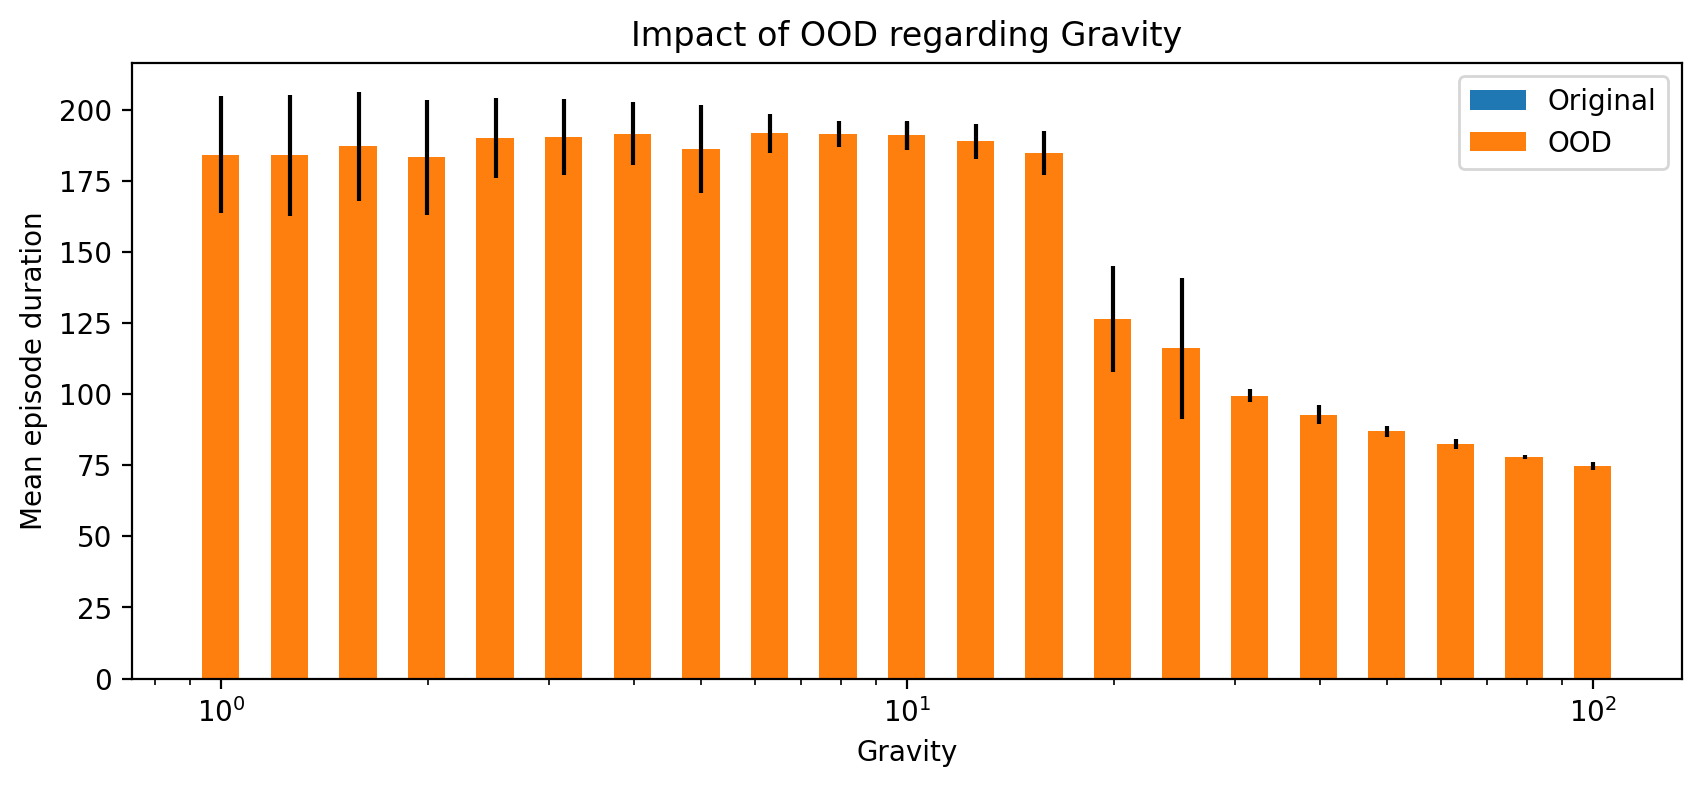

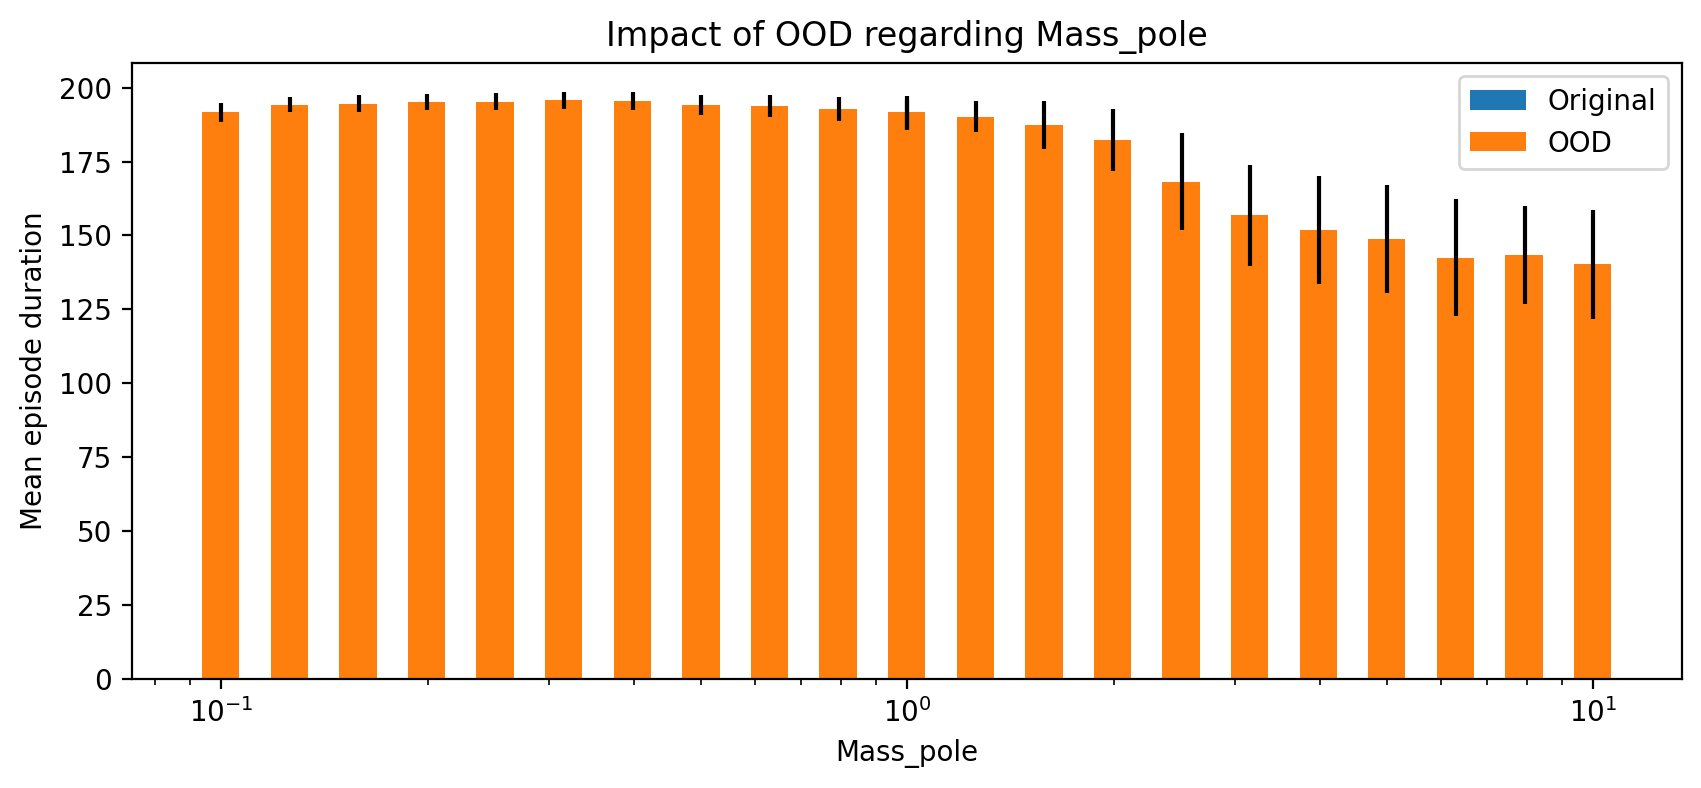

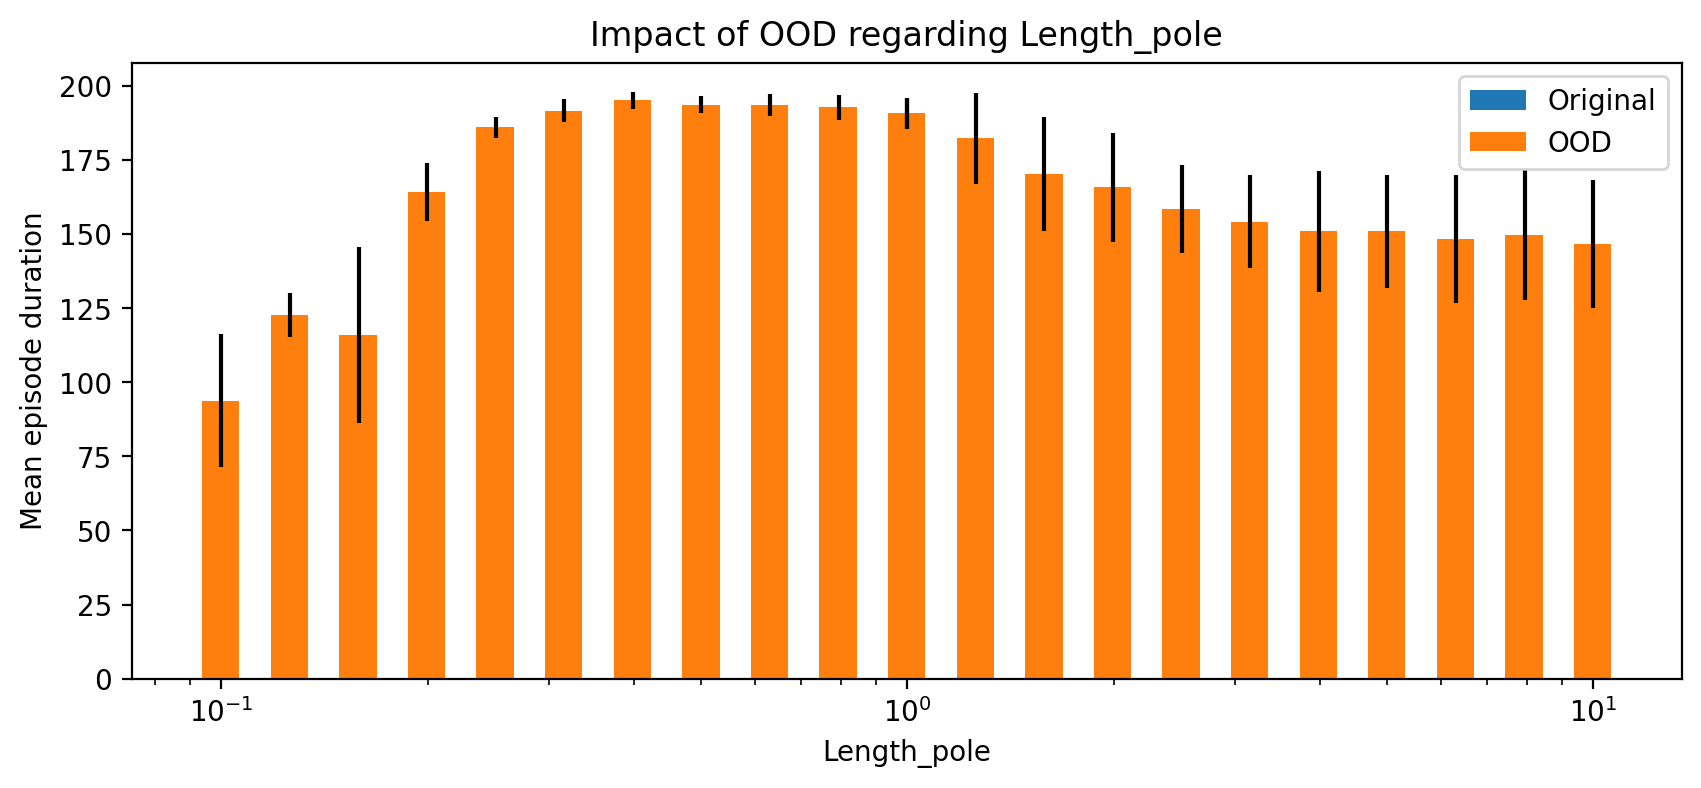

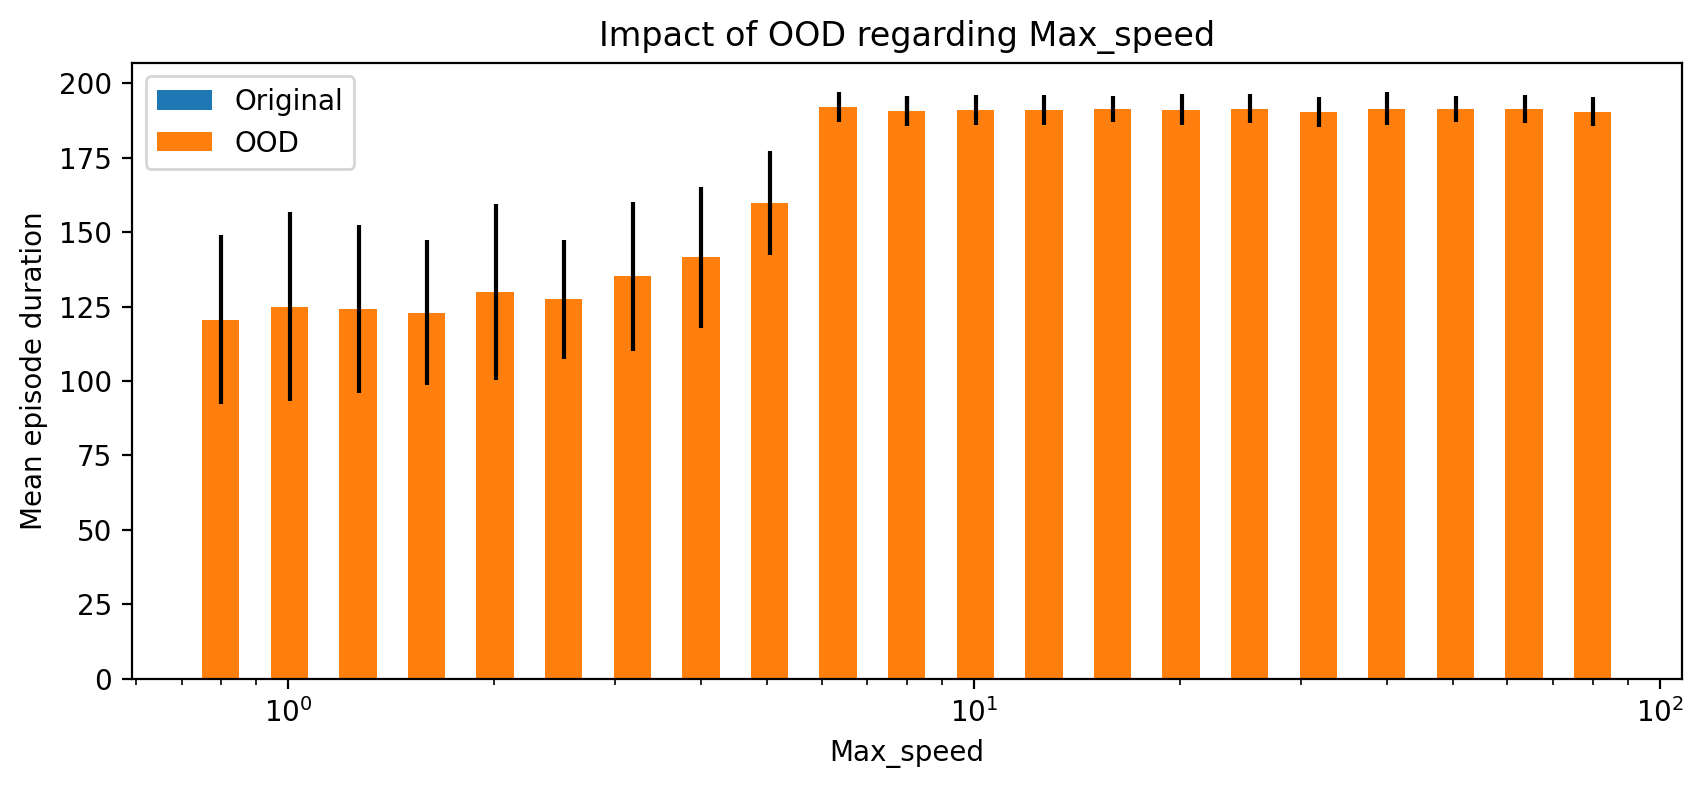

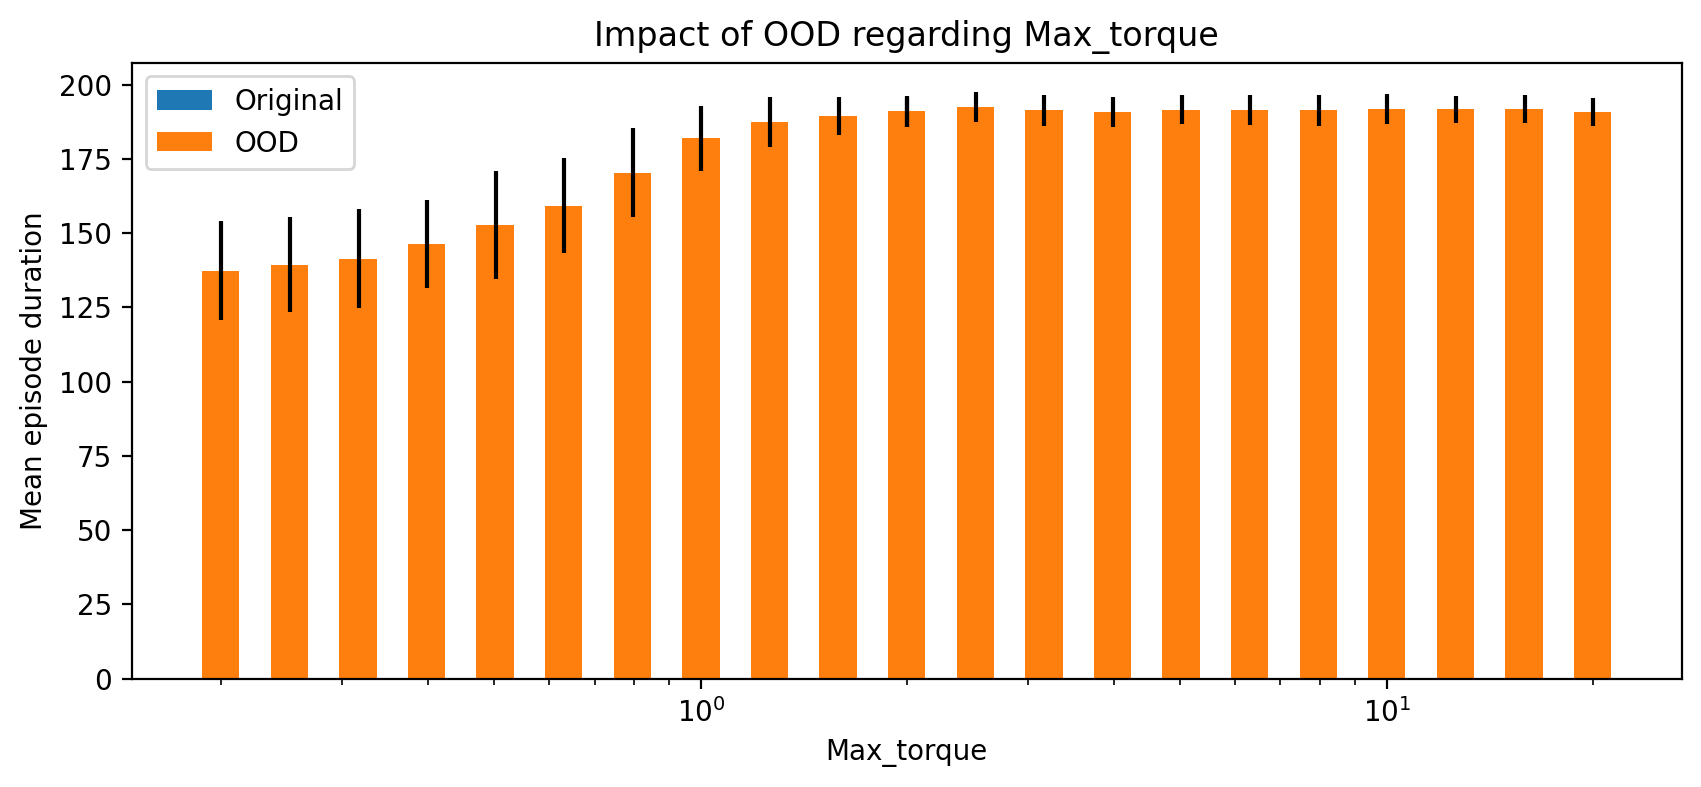

In [10]:
for key in results:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    
    default_width = default_values[key]/8.0
    width = default_width * np.logspace(-1, 1, num=21)
    #np.array([2**i for i in range(-5, 0)] + [2**i for i in range(1, 5+1)])

    ax.bar(default_values[key], original_result, yerr=original_std_result, width=default_width, label='Original')
    ax.bar(values[key], results[key], yerr=std_results[key], width=width, label='OOD')
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    

# Create OOD detector

The configuration ood detector is relative to its default environment

In [11]:
env = instanciation_function(default_values)
ood_detector = MartingaleOODDetector(env, verbose=False)
print("Config", default_values)
print("In distrib OOD score:", ood_detector.get_in_distrib_score())

NameError: name 'trunc' is not defined

We have a low ood score on the delaut environment

It should be higher on ood environment

In [ ]:
ood_config = get_ood_configs(default_values, values)[9]
ood_env = instanciation_function(ood_config)
print("Config", default_values)
print("OOD score:", ood_detector.test_ood(ood_env, nb_steps=100))

Config {'Gravity': 9.8, 'Mass_cart': 1.0, 'Length_pole': 0.5, 'Mass_pole': 0.1, 'Force_magnitude': 10.0}
OOD score: 0.2524469315388347


Let's compute the ood scores of the previously studies ood environments

In [ ]:
mean_ood_scores = {}
std_ood_scores = {}

original_env = instanciation_function(default_values)
agent = ALGO.load(path_agent, env=original_env)
ood_detector = MartingaleOODDetector(env)
in_distrib_score = ood_detector.get_in_distrib_score()

for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_scores:
        mean_ood_scores[config['change']] = []
        std_ood_scores[config['change']] = []
    
    ood_env = instanciation_function(config)
    agent = ALGO.load(path_agent)
    list_scores = np.array([ood_detector.test_ood(ood_env, nb_steps=100) for _ in range(10)])
    ood_score = list_scores.mean()
    std_score = list_scores.std()

    mean_ood_scores[config['change']].append(ood_score)
    std_ood_scores[config['change']].append(std_score)

  0%|          | 0/105 [00:00<?, ?it/s]

We now realise a plot of the mean reward and ood scores of each environment. The ones of the delaut environment are in darker colour at the middle of the plot.

  0%|          | 0/5 [00:00<?, ?it/s]

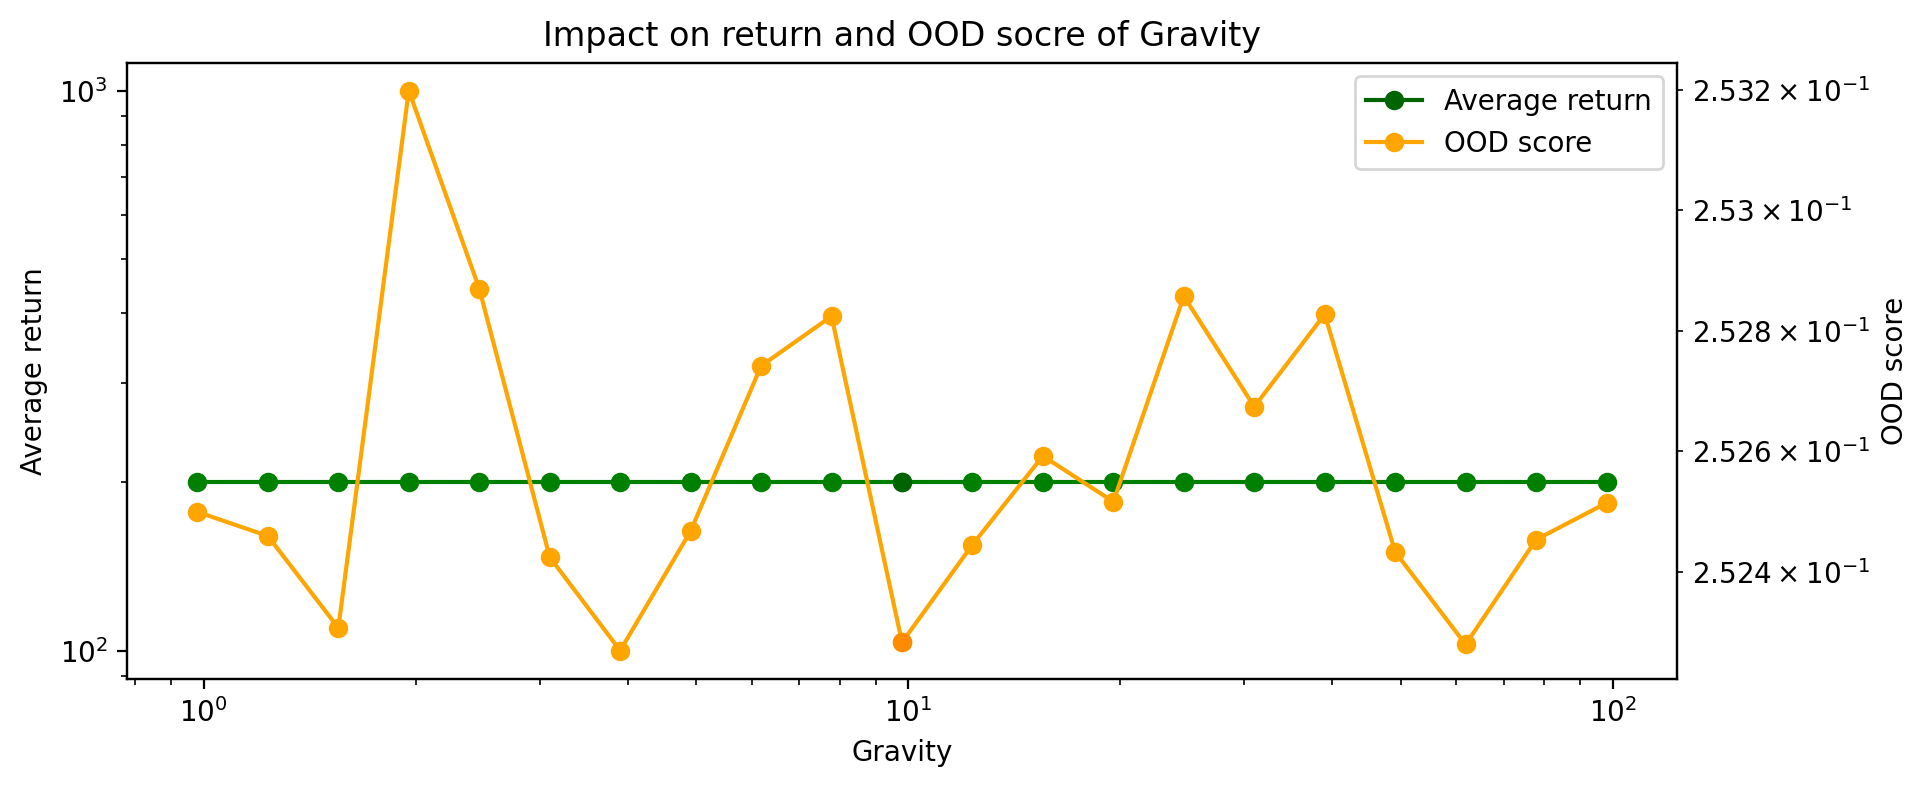

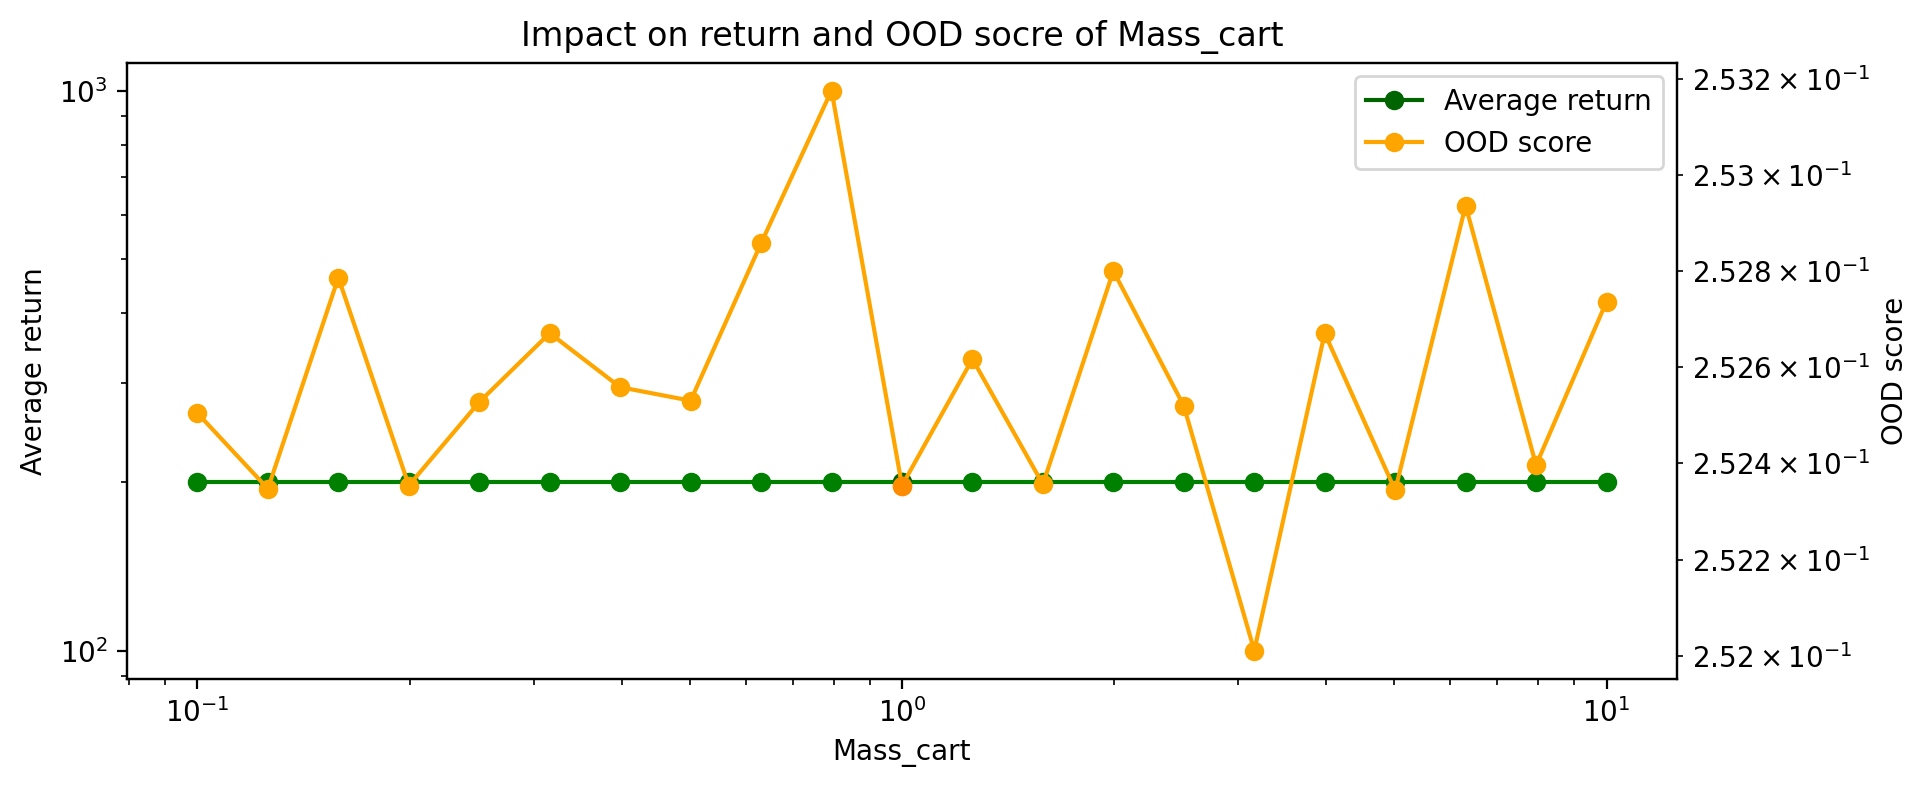

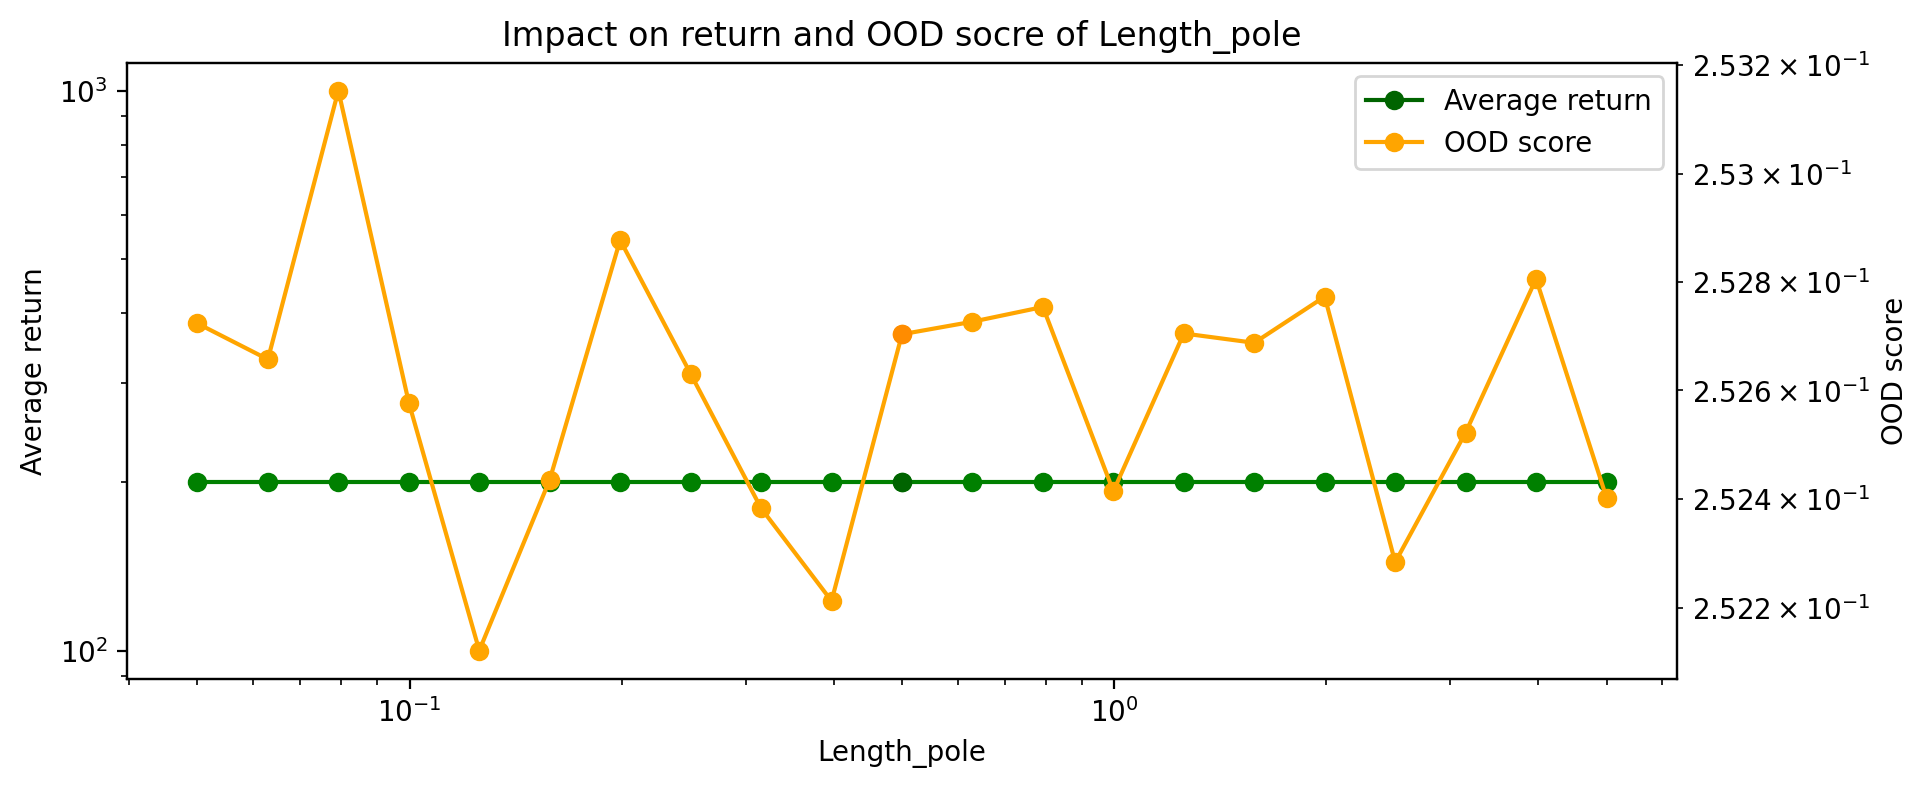

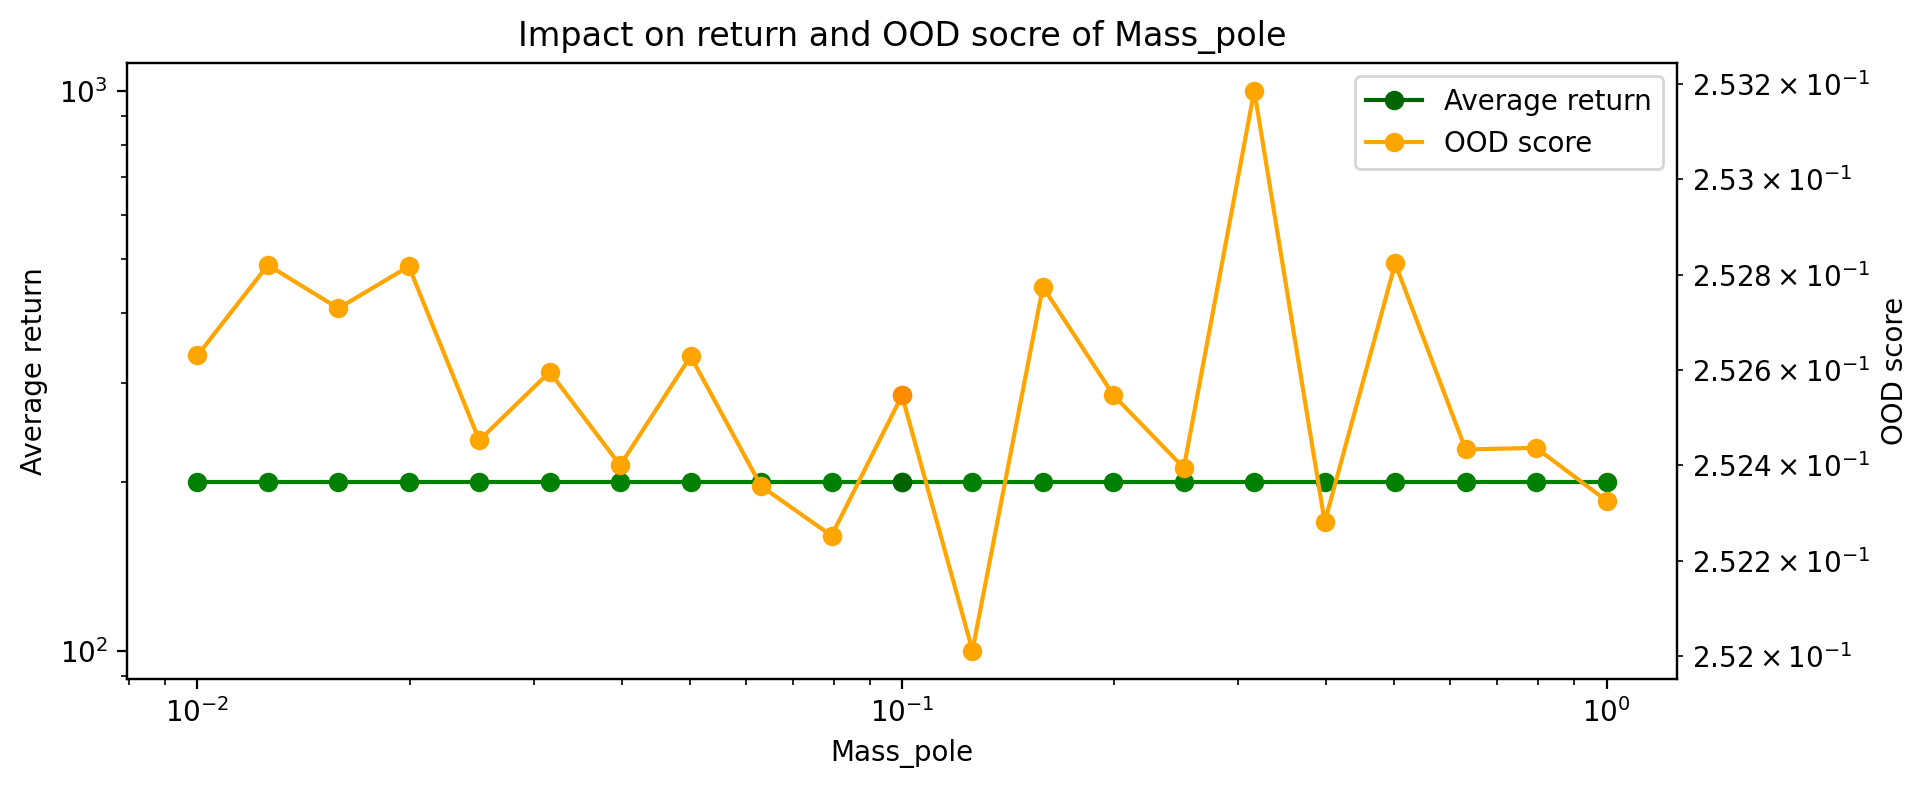

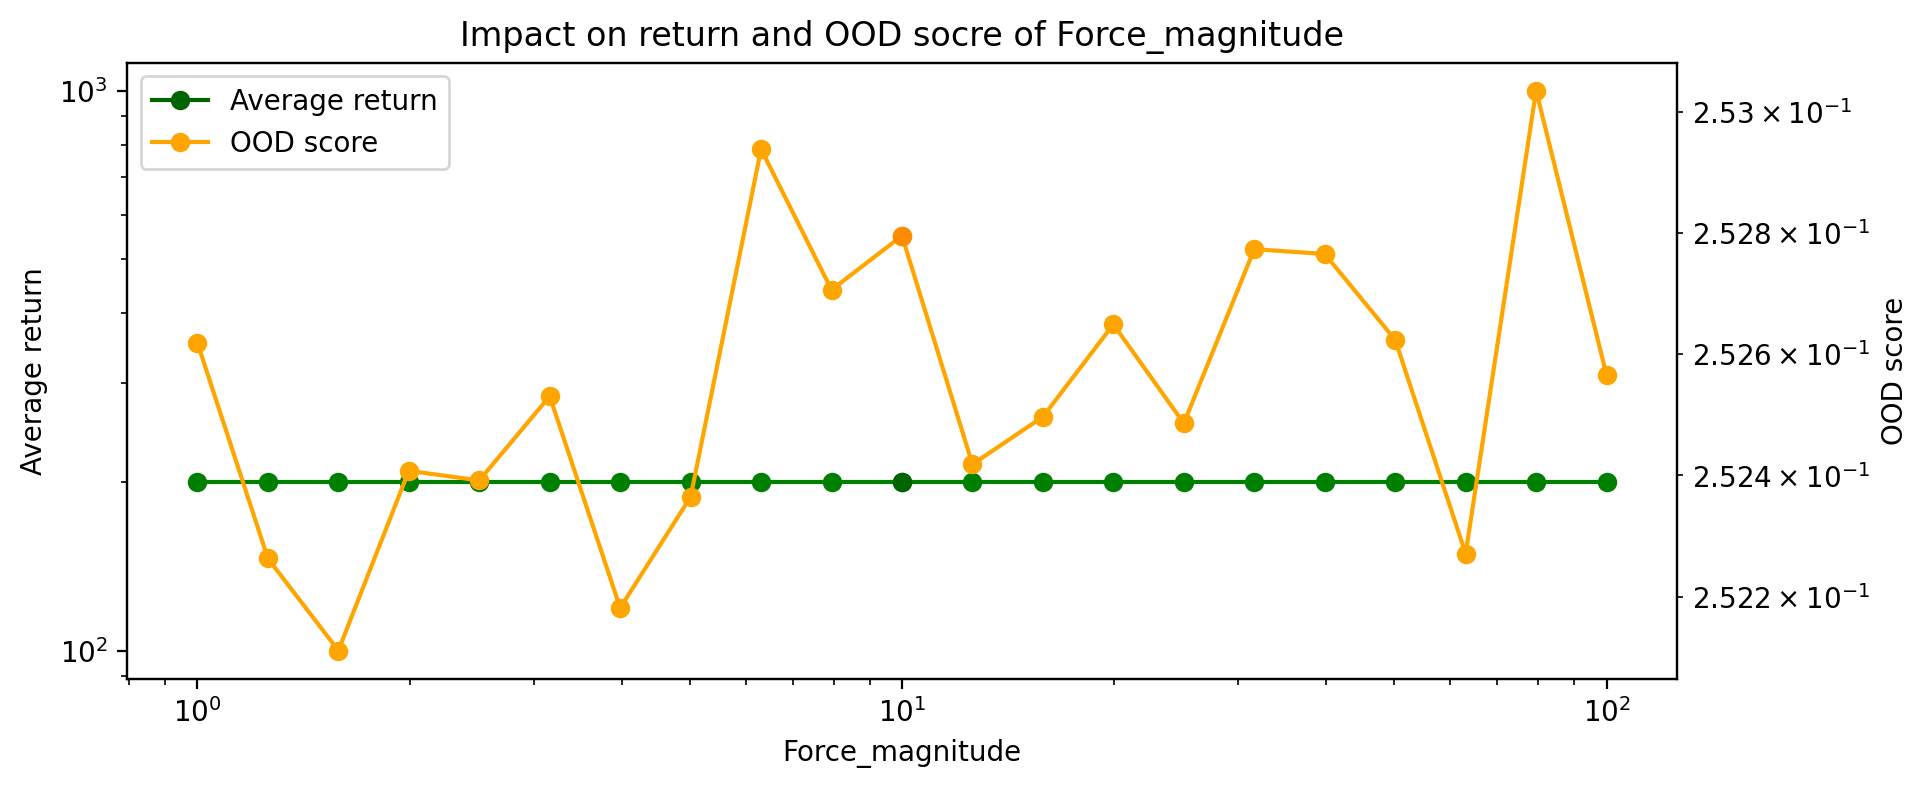

In [ ]:
from turtle import color
from numpy import inf


for key in tqdm(results):
    plot_to_compare(values[key], 
                    np.array(results[key]), 
                    mean_ood_scores[key], 
                    title='Impact on return and OOD socre of '+key, 
                    X_label=key,
                    Y1_label='Average return',
                    Y2_label='OOD score',
                    n_default=10,
                    save_path=path/'imgs'
                    )
    """fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    default_width = default_values[key]/8.0
    width = default_width * np.logspace(-1, 1, num=21)

    ax.bar(default_values[key]- default_width/4, 1.0, width=default_width/2, label='Relative return', color='darkgreen')
    ax.bar(values[key]- width/4, results[key]/original_result, width=width/2,  color='green')

    ax.bar(default_values[key]+default_width/4, 1.0, width=default_width/2, label='Relative OOD score', color='darkorange')
    ax.bar(values[key]+ width/4, mean_ood_scores[key]/in_distrib_score, width=width/2, color='orange', yerr=std_ood_scores[key])
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)

    plt.legend() #prop={'size': 'medium'}, ncol=2)"""
   

We add as maning in distribution examples and there are ood examples

In [ ]:
original_env = instanciation_function(default_values)
agent = ALGO.load(path_agent, env=original_env)

list_scores = []
for _ in trange(5*18):
    list_scores.append(np.array([ood_detector.test_ood(original_env, nb_steps=100) for _ in range(10)]).mean())

mean_ood_scores['None'] = list_scores

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:34<00:00,  2.62it/s]


# Detection speed at a fixed threshold

In [ ]:
original_env = instanciation_function(default_values)
list_scores = np.array([ood_detector.test_ood(original_env, nb_steps=1000) for _ in range(100)])
ood_score = list_scores.mean()
std_score = list_scores.std()
threshold = ood_score + 10*std_score

ood_score, std_score, threshold

(0.25362097283347407, 0.00028731326049688896, 0.256494105438443)

In [ ]:
np.array([ood_detector.test_ood(original_env, nb_steps=100) for _ in range(100)]) > threshold

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
ood_detector = MartingaleOODDetector(original_env)

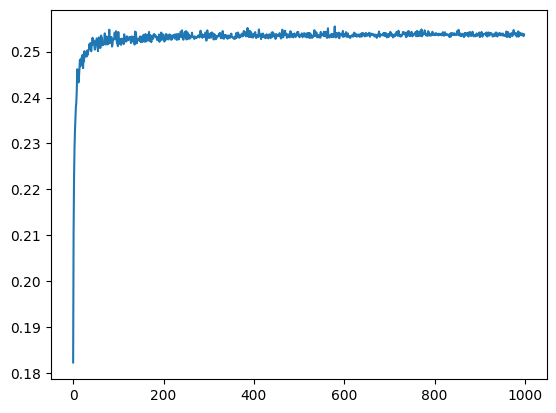

In [ ]:
Y = [ood_detector.test_ood(original_env, nb_steps=n) for n in range(1,1000)]
plt.plot(Y)

In [ ]:
stop_in_distrib, ood_in_distrib = ood_detector.stop_above_threshold(original_env, threshold, start_at=50, nb_steps=1000)

In [ ]:

mean_ood_stops = {}
std_ood_stops = {}

original_env = instanciation_function(default_values)
agent = ALGO.load(path_agent, env=original_env)
ood_detector = MartingaleOODDetector(env)


for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_stops:
        mean_ood_stops[config['change']] = []
        std_ood_stops[config['change']] = []
    
    ood_env = instanciation_function(config)
    agent = ALGO.load(path_agent)
    list_stops = np.array([ood_detector.stop_above_threshold(original_env, threshold, start_at=30, nb_steps=1000)[0] for _ in range(10)])
    mean_ood_stop = list_stops.mean()
    std_ood_stop = list_stops.std()

    #mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=10)

    mean_ood_stops[config['change']].append(mean_ood_stop)
    std_ood_stops[config['change']].append(std_ood_stop)
    #print(config, mean_reward)
    



  0%|          | 0/105 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
original_result = 1000.0
stop_in_distrib = 100.0

In [ ]:
from turtle import color
from numpy import inf


for key in tqdm(results):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)

    plot_to_compare(values[key], 
                    results[key], 
                    mean_ood_stops[key], 
                    title='Impact on return and OOD socre of '+key, 
                    X_label=key,
                    Y1_label='Average return',
                    Y2_label='OOD score',
                    n_default=10,
                    save_path=path/'imgs'
                    )
    """ax.set_xscale('log')
    ax.set_yscale('log')
    ax2=ax.twinx()
    ax2.set_yscale('log')
    
    default_width = default_values[key]/12.0
    width = default_width * np.logspace(-1, 1, num=21)

    ax.plot(values[key], results[key], label='Mean return', marker='o',color='green')
    ax.plot(default_values[key], original_result, marker='o',color='darkgreen')
    
    ax2.plot([], [], marker='o',color='darkgreen', label='Mean return')
    ax2.plot(values[key], mean_ood_stops[key], label='OOD stop', marker='o',color='orange')
    ax2.plot(default_values[key], stop_in_distrib,  marker='o',color='darkorange')
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)

    plt.legend() #prop={'size': 'medium'}, ncol=2)"""
   

# Computation of the AUC score

In [ ]:
def compute_AUC(mean_ood_scores, plot=True, verbose=False):
    TPRs = []
    FPRs = []

    thresholds = [10**(-i/10) for i in range(-50, 50+1)]
    for threshold in thresholds:
        false_pos=0
        false_neg=0
        true_pos=0
        true_neg=0

        for key in mean_ood_scores:
            if str(key) != 'None': # Env OOD
                for test_res in mean_ood_scores[key]:

                    if test_res<threshold: # Not detected as OOD
                        false_neg +=1
                    else:
                        true_pos +=1
            else: # Env standard
                for test_res in mean_ood_scores[key]:

                    if test_res>threshold: # Detected as OOD
                        false_pos +=1
                    else:
                        true_neg +=1


        try:
            tpr = true_pos/(true_pos+false_neg)
        except ZeroDivisionError:
            print('error computing tpr')
            continue
            tpr = 1.0
        
        try:
            fpr = false_pos/(false_pos+true_neg)
        except ZeroDivisionError:
            print('error computing fpr')
            continue

        if verbose:
            print(threshold)
            print('TP', true_pos, 'FP',false_pos)
            print('FN', false_neg, 'TN',true_neg)
            print()
            print(tpr, fpr)
        TPRs.append(tpr)
        FPRs.append(fpr)
        #AUC += tpr/len(thresholds)

    if verbose:
        plt.title("TPR and FPR curves")
        plt.plot(TPRs, label='TPR')
        plt.plot(FPRs, label='FPR')
        plt.legend()
        plt.show()
        
    #print('AUC: ', AUC)
    plt.title("ROC curve")
    plt.plot(FPRs, TPRs,'-*')
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.show()

    AUC = integrate.simps(x=FPRs, y=TPRs, even='avg')
    return AUC

In [ ]:
compute_AUC(mean_ood_scores)